In [1]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import pickle

from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, LSTM, TimeDistributed, InputLayer, Reshape, BatchNormalization, Bidirectional

2022-12-15 18:39:36.344306: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
metadata = pd.read_csv("/datasets/nicolas_facchinetti/processed_data/ravdess/metadata_final.csv")
# metadata = pd.read_csv("D:\\Scuola\\TesiMag\\thesis_adversarial_ml_audio\\processed_data//emodb/metadata_final.csv")
metadata

,path,filename,chunk,label,actor,gender,mod
0,/datasets/nicolas_facchinetti/ravdess/data/Act...,03-01-08-01-02-02-15.wav,0,surprised,Actor_15,m,0
1,/datasets/nicolas_facchinetti/ravdess/data/Act...,03-01-08-01-02-02-15.wav,0,surprised,Actor_15,m,1
2,/datasets/nicolas_facchinetti/ravdess/data/Act...,03-01-08-01-02-02-15.wav,0,surprised,Actor_15,m,1
3,/datasets/nicolas_facchinetti/ravdess/data/Act...,03-01-08-01-02-02-15.wav,0,surprised,Actor_15,m,1
4,/datasets/nicolas_facchinetti/ravdess/data/Act...,03-01-08-01-02-02-15.wav,0,surprised,Actor_15,m,1
...,...,...,...,...,...,...,...
8947,/datasets/nicolas_facchinetti/ravdess/data/Act...,03-01-07-01-01-02-13.wav,0,disgust,Actor_13,m,1
8948,/datasets/nicolas_facchinetti/ravdess/data/Act...,03-01-07-01-01-02-13.wav,0,disgust,Actor_13,m,2
8949,/datasets/nicolas_facchinetti/ravdess/data/Act...,03-01-07-01-01-02-13.wav,0,disgust,Actor_13,m,2
8950,/datasets/nicolas_facchinetti/ravdess/data/Act...,03-01-07-01-01-02-13.wav,0,disgust,Actor_13,m,2


0: no normalization technique<br>1: sum of each matrix cell equal 1<br>2: each cell in matrix is divided by the maximum value of the matrix<br>3: MinMax scaler to each sample's matrix

In [3]:
data0 = pickle.load(open("/datasets/nicolas_facchinetti/processed_data/ravdess/processed_data0.p", "rb" ))
data1 = pickle.load(open("/datasets/nicolas_facchinetti/processed_data/ravdess/processed_data1.p", "rb" ))
data2 = pickle.load(open("/datasets/nicolas_facchinetti/processed_data/ravdess/processed_data2.p", "rb" ))
data3 = pickle.load(open("/datasets/nicolas_facchinetti/processed_data/ravdess/processed_data3.p", "rb" ))
data0['x'].shape, data0['y'].shape, data1['x'].shape, data1['y'].shape, data2['x'].shape, data2['y'].shape, data3['x'].shape, data3['y'].shape,

((8952, 261, 128, 1),
 (8952, 5),
 (8952, 261, 128, 1),
 (8952, 5),
 (8952, 261, 128, 1),
 (8952, 5),
 (8952, 261, 128, 1),
 (8952, 5))

In [4]:
import matplotlib.pyplot as plt
from collections.abc import Iterable

def plot_res_acc(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_res_loss(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_stats(h):
    fig = plt.gcf()
    fig.set_size_inches(15, 15)
    for num, c in enumerate(h):
        n = (num+1)*2
        plot_res_acc(c, len(h), n-1)
        plot_res_loss(c, len(h), n)
    plt.show()

In [5]:
def train_evaluate(model_fn, train, val, opt='adam'):
    m = model_fn()
    m.compile(loss='categorical_crossentropy', optimizer=opt, metrics='accuracy')
    # fit & predict
    history = m.fit(train[0], train[1],
                    epochs=50,
                    batch_size=32,
                    validation_data=(val[0], val[1]),
                    verbose=1)
    print("Done")
    return history

In [6]:
from sklearn.model_selection import train_test_split

def train_kfold(model_fn, x, y, metadata, n=[1997,1941,1965]):    
    results = []
    
    for rs in n:
        train_df, test_df = train_test_split(metadata, 
                                   test_size = 0.15, 
                                   random_state = rs,
                                   stratify = metadata['label'])
        train_index = train_df.index
        test_index = test_df.index
        x_train = x[train_index]
        y_train = y[train_index]
        x_test = x[test_index]
        y_test = y[test_index]
        
        results.append(train_evaluate(model_fn, (x_train, y_train), (x_test, y_test)))
    return results

# Model definition

In [7]:
def get_m():
    m = Sequential([
            InputLayer(input_shape=(261,128,1)),
            Reshape((9,29,128,1)),
            TimeDistributed(Conv2D(16, kernel_size=(5,5), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(4,4), strides=2)),

            TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),
            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),
            
            LSTM(3, return_sequences=False, dropout=0.2),
            Dense(5, activation='softmax')
    ])
    return m

get_m().summary()

2022-12-15 18:39:40.069264: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-15 18:39:40.070092: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-15 18:39:40.172358: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:15:00.0 name: NVIDIA TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 607.97GiB/s
2022-12-15 18:39:40.172404: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-15 18:39:40.175814: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-15 18:39:40.175919: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 9, 29, 128, 1)     0         
_________________________________________________________________
time_distributed (TimeDistri (None, 9, 25, 124, 16)    416       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 9, 25, 124, 16)    64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 9, 11, 61, 16)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 9, 9, 59, 32)      4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 9, 4, 29, 32)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 9, 2, 27, 64)      1

# Without standardization

In [8]:
l0 = train_kfold(get_m, data0['x'], data0['y'], metadata)

2022-12-15 18:39:42.103950: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-15 18:39:42.121226: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3301490000 Hz


Epoch 1/50


2022-12-15 18:39:43.132678: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-15 18:39:43.333079: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


238/238 [==============================] - 7s 17ms/step - loss: 1.5760 - accuracy: 0.2673 - val_loss: 1.5649 - val_accuracy: 0.2591
Epoch 2/50
238/238 [==============================] - 3s 14ms/step - loss: 1.5290 - accuracy: 0.2908 - val_loss: 1.5112 - val_accuracy: 0.2941
Epoch 3/50
238/238 [==============================] - 3s 14ms/step - loss: 1.4874 - accuracy: 0.3185 - val_loss: 1.4975 - val_accuracy: 0.3187
Epoch 4/50
238/238 [==============================] - 3s 14ms/step - loss: 1.4807 - accuracy: 0.3310 - val_loss: 1.4995 - val_accuracy: 0.3179
Epoch 5/50
238/238 [==============================] - 3s 14ms/step - loss: 1.4680 - accuracy: 0.3433 - val_loss: 1.4938 - val_accuracy: 0.3418
Epoch 6/50
238/238 [==============================] - 3s 14ms/step - loss: 1.4347 - accuracy: 0.3647 - val_loss: 1.4765 - val_accuracy: 0.3366
Epoch 7/50
238/238 [==============================] - 3s 14ms/step - loss: 1.4450 - accuracy: 0.3496 - val_loss: 1.5411 - val_accuracy: 0.2897
Epoch 8/50

238/238 [==============================] - 3s 15ms/step - loss: 1.4835 - accuracy: 0.3404 - val_loss: 1.4886 - val_accuracy: 0.3299
Epoch 9/50
238/238 [==============================] - 3s 15ms/step - loss: 1.4833 - accuracy: 0.3276 - val_loss: 1.4851 - val_accuracy: 0.3321
Epoch 10/50
238/238 [==============================] - 3s 14ms/step - loss: 1.4728 - accuracy: 0.3289 - val_loss: 1.4850 - val_accuracy: 0.3135
Epoch 11/50
238/238 [==============================] - 3s 14ms/step - loss: 1.4652 - accuracy: 0.3366 - val_loss: 1.4764 - val_accuracy: 0.3388
Epoch 12/50
238/238 [==============================] - 3s 15ms/step - loss: 1.4730 - accuracy: 0.3387 - val_loss: 1.5487 - val_accuracy: 0.2561
Epoch 13/50
238/238 [==============================] - 3s 14ms/step - loss: 1.4712 - accuracy: 0.3315 - val_loss: 1.5129 - val_accuracy: 0.3254
Epoch 14/50
238/238 [==============================] - 3s 15ms/step - loss: 1.4663 - accuracy: 0.3469 - val_loss: 1.4751 - val_accuracy: 0.3403
Epoch

238/238 [==============================] - 3s 15ms/step - loss: 1.2271 - accuracy: 0.5131 - val_loss: 1.2938 - val_accuracy: 0.4758
Epoch 16/50
238/238 [==============================] - 3s 14ms/step - loss: 1.2041 - accuracy: 0.5282 - val_loss: 1.2944 - val_accuracy: 0.4609
Epoch 17/50
238/238 [==============================] - 3s 15ms/step - loss: 1.1805 - accuracy: 0.5411 - val_loss: 1.2657 - val_accuracy: 0.4773
Epoch 18/50
238/238 [==============================] - 3s 15ms/step - loss: 1.1646 - accuracy: 0.5473 - val_loss: 1.2397 - val_accuracy: 0.4922
Epoch 19/50
238/238 [==============================] - 3s 15ms/step - loss: 1.1412 - accuracy: 0.5543 - val_loss: 1.2542 - val_accuracy: 0.4914
Epoch 20/50
238/238 [==============================] - 3s 15ms/step - loss: 1.1079 - accuracy: 0.5721 - val_loss: 1.2133 - val_accuracy: 0.5130
Epoch 21/50
238/238 [==============================] - 3s 15ms/step - loss: 1.0829 - accuracy: 0.5791 - val_loss: 1.1889 - val_accuracy: 0.5257
Epoc

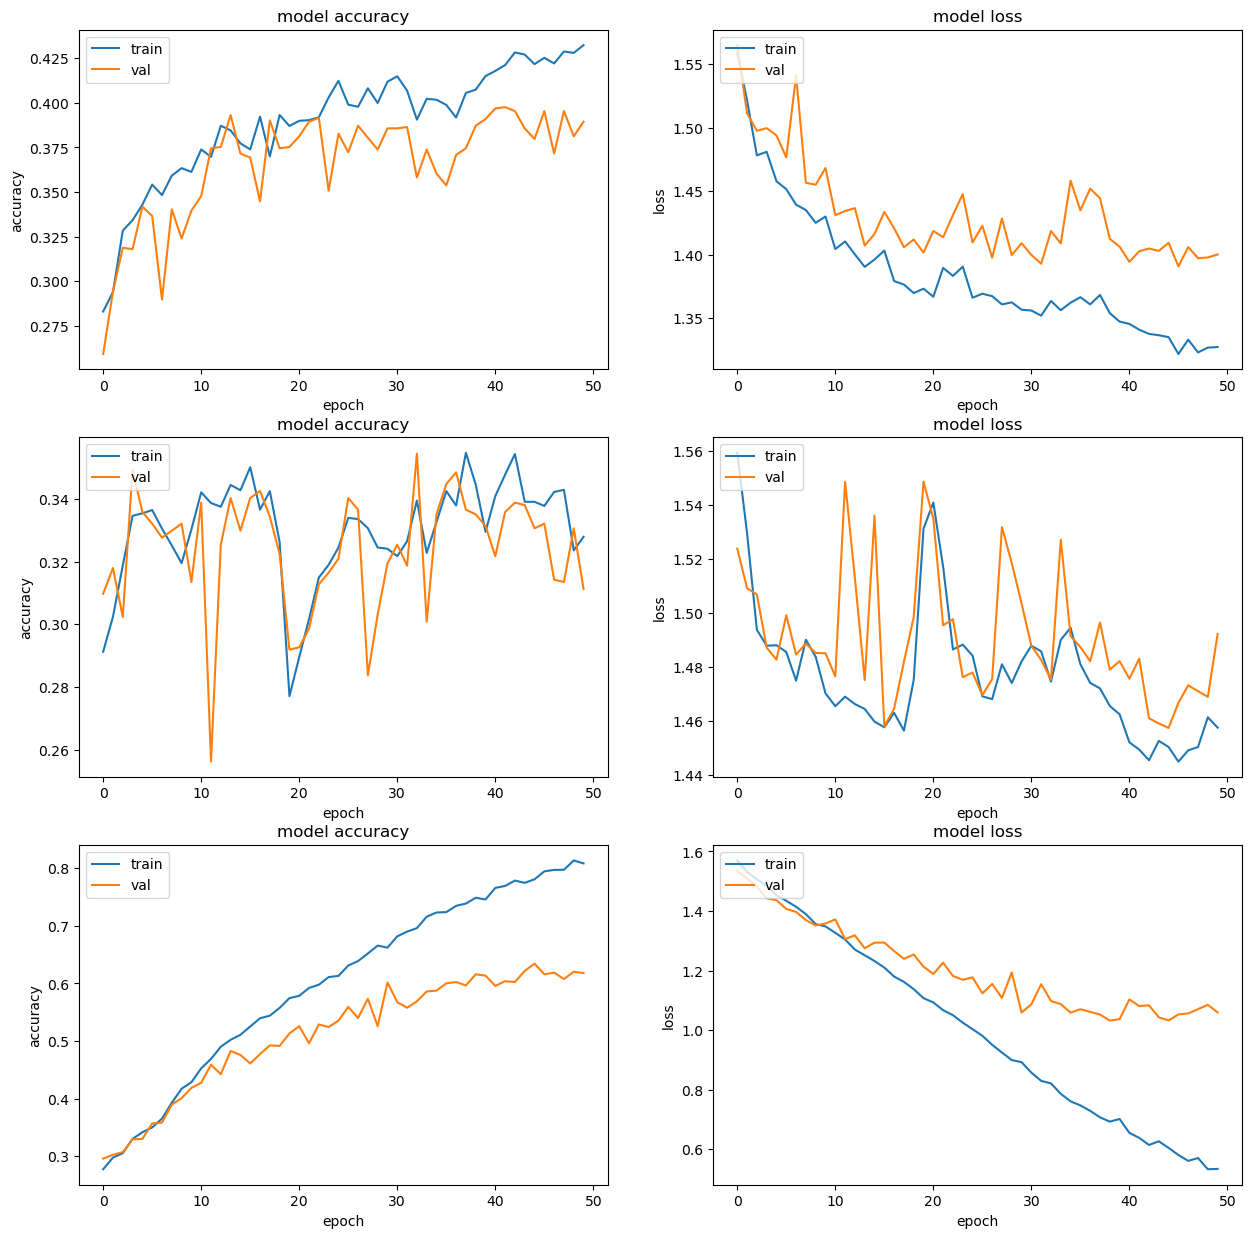

In [9]:
plot_stats(l0)

In [10]:
l1 = train_kfold(get_m, data1['x'], data1['y'], metadata)


Epoch 1/50
238/238 [==============================] - 5s 16ms/step - loss: 1.6048 - accuracy: 0.2155 - val_loss: 1.6095 - val_accuracy: 0.2003
Epoch 2/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6094 - accuracy: 0.2091 - val_loss: 1.6093 - val_accuracy: 0.2063
Epoch 3/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6094 - accuracy: 0.2042 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 4/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6094 - accuracy: 0.2047 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 5/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6093 - accuracy: 0.2128 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 6/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6096 - accuracy: 0.1893 - val_loss: 1.6093 - val_accuracy: 0.2063
Epoch 7/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6098 - accuracy: 0.1979 - val_loss: 1.6093 - val_accuracy: 0.2063

Epoch 8/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6093 - accuracy: 0.2058 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 9/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6088 - accuracy: 0.2132 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 10/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6091 - accuracy: 0.2074 - val_loss: 1.6093 - val_accuracy: 0.2063
Epoch 11/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6094 - accuracy: 0.2056 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 12/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6092 - accuracy: 0.2079 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 13/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6096 - accuracy: 0.2018 - val_loss: 1.6093 - val_accuracy: 0.2063
Epoch 14/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6089 - accuracy: 0.2157 - val_loss: 1.6092 - val_accuracy: 0

Epoch 15/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6094 - accuracy: 0.2018 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 16/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6093 - accuracy: 0.2101 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 17/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6090 - accuracy: 0.2028 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 18/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6097 - accuracy: 0.2032 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 19/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6095 - accuracy: 0.2079 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 20/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6089 - accuracy: 0.2072 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 21/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6096 - accuracy: 0.2006 - val_loss: 1.6092 - val_accuracy:

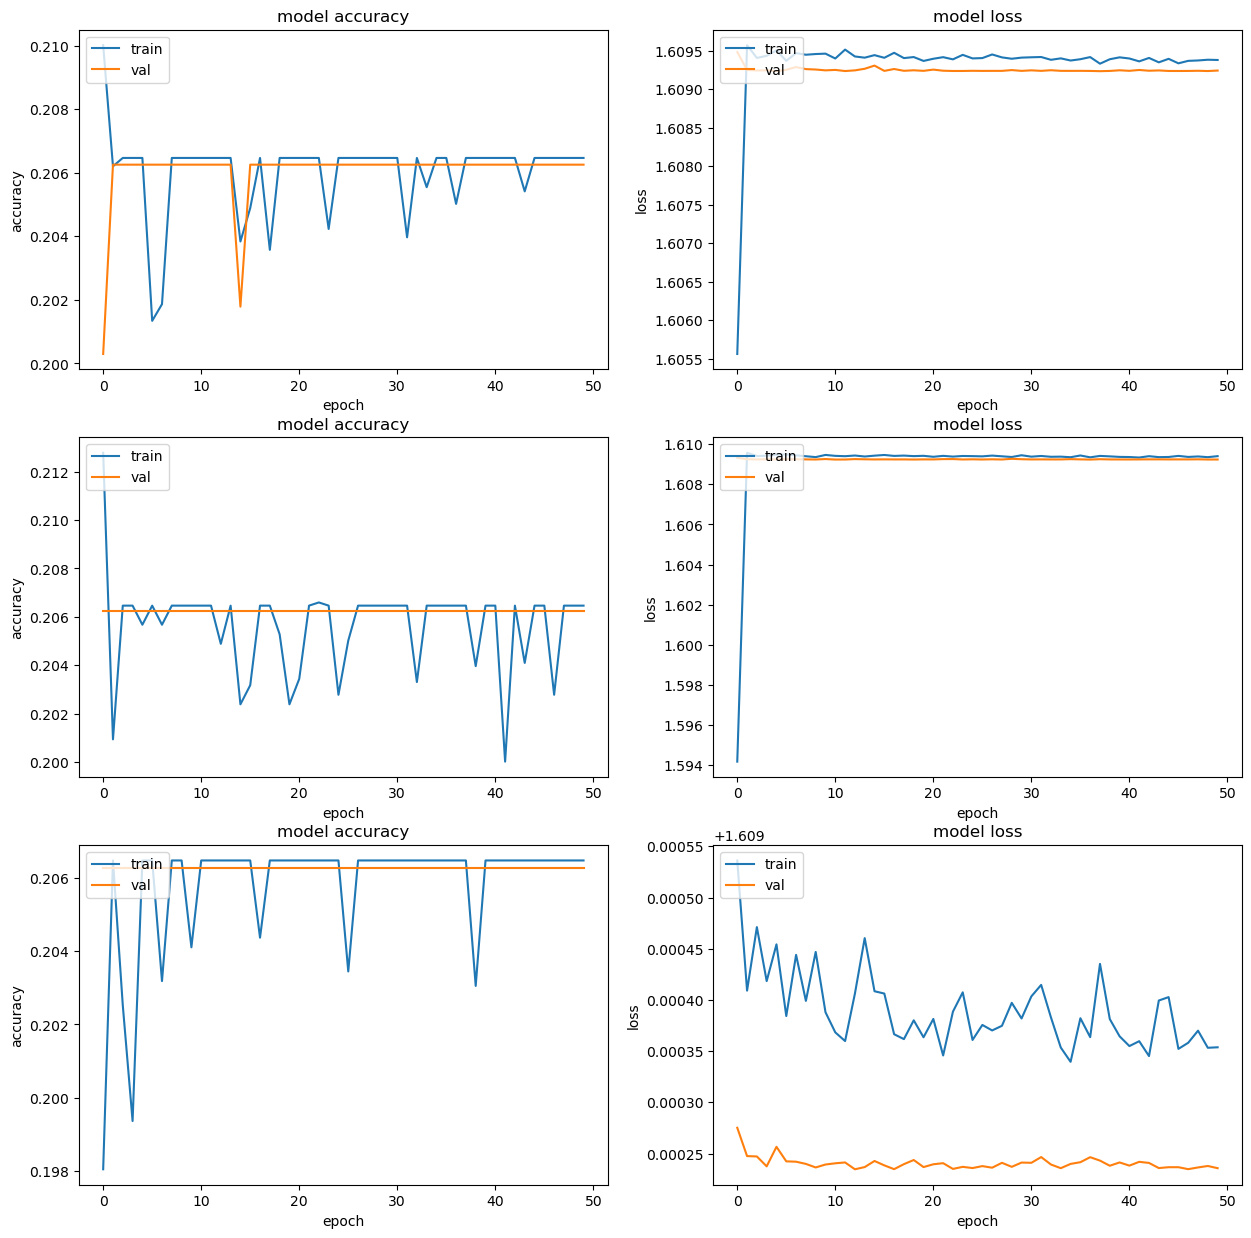

In [11]:
plot_stats(l1)

In [12]:
l2 = train_kfold(get_m, data2['x'], data2['y'], metadata)

Epoch 1/50
238/238 [==============================] - 5s 16ms/step - loss: 1.5656 - accuracy: 0.2653 - val_loss: 1.6093 - val_accuracy: 0.2018
Epoch 2/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6093 - accuracy: 0.2131 - val_loss: 1.6094 - val_accuracy: 0.2018
Epoch 3/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6096 - accuracy: 0.2010 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 4/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6094 - accuracy: 0.2049 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 5/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6089 - accuracy: 0.2036 - val_loss: 1.6093 - val_accuracy: 0.2063
Epoch 6/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6092 - accuracy: 0.2050 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 7/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6092 - accuracy: 0.2079 - val_loss: 1.6092 - val_accuracy: 0.2063

Epoch 8/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6095 - accuracy: 0.2059 - val_loss: 1.6093 - val_accuracy: 0.2063
Epoch 9/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6095 - accuracy: 0.2061 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 10/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6095 - accuracy: 0.2039 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 11/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6092 - accuracy: 0.2049 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 12/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6099 - accuracy: 0.2036 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 13/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6094 - accuracy: 0.2023 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 14/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6099 - accuracy: 0.1989 - val_loss: 1.6093 - val_accuracy: 0

Epoch 15/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6095 - accuracy: 0.2087 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 16/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6091 - accuracy: 0.2042 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 17/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6094 - accuracy: 0.2068 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 18/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6095 - accuracy: 0.2063 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 19/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6092 - accuracy: 0.2074 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 20/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6094 - accuracy: 0.2037 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 21/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6093 - accuracy: 0.2060 - val_loss: 1.6093 - val_accuracy:

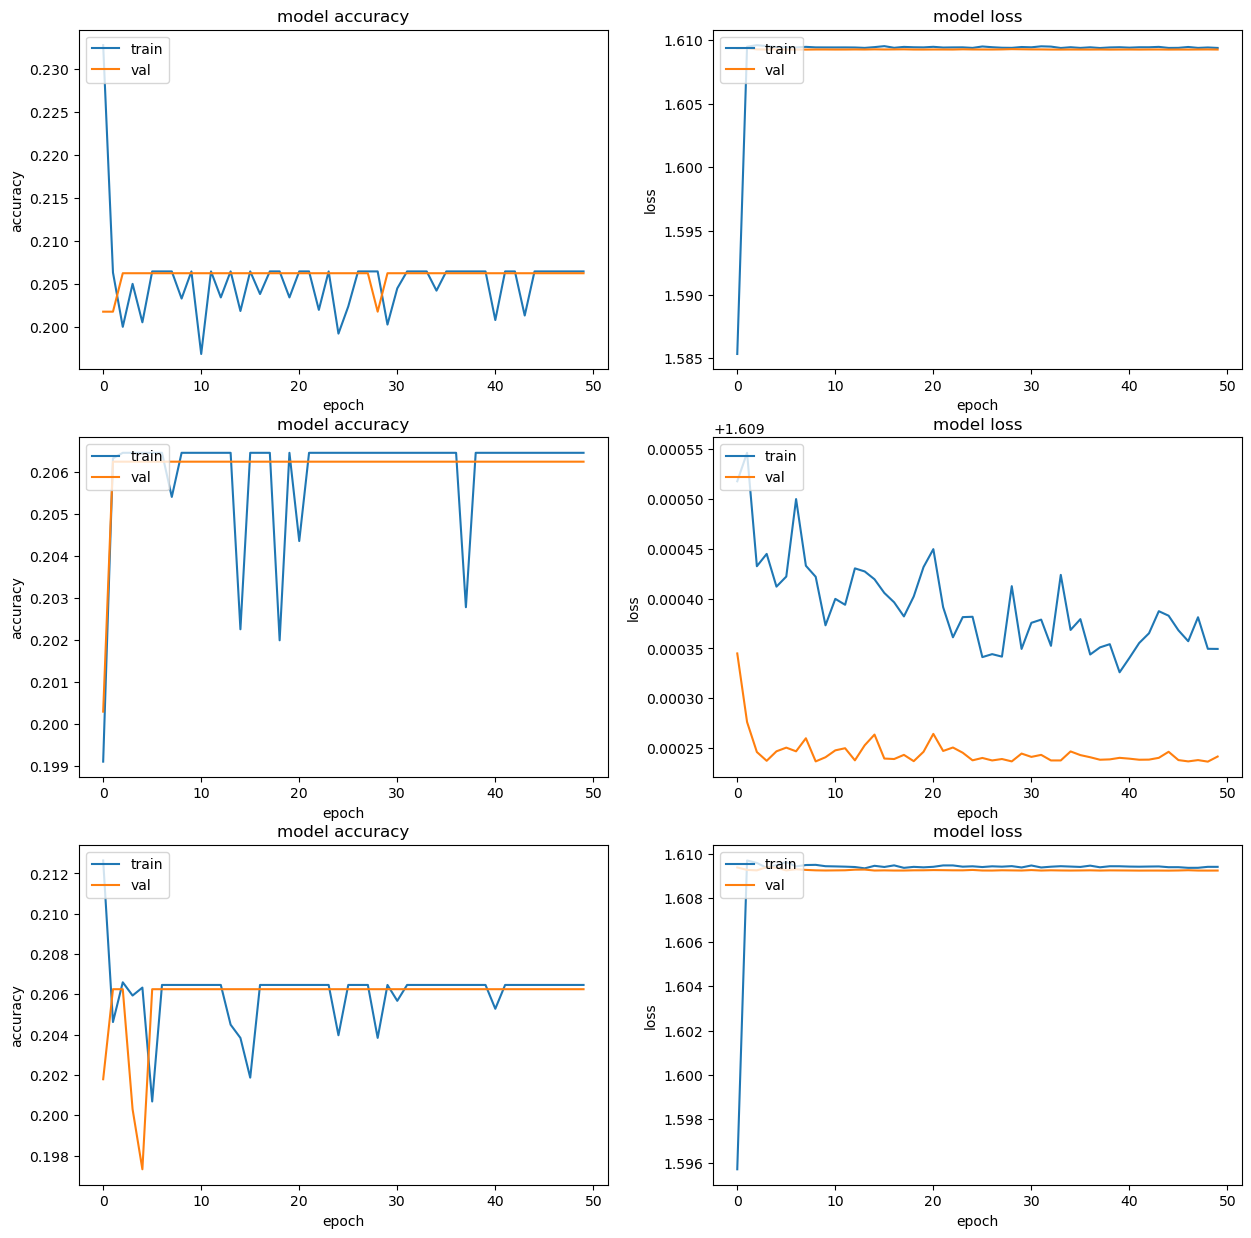

In [13]:
plot_stats(l2)

In [14]:
l3 = train_kfold(get_m, data3['x'], data3['y'], metadata)

Epoch 1/50
238/238 [==============================] - 5s 16ms/step - loss: 1.6104 - accuracy: 0.1885 - val_loss: 1.6076 - val_accuracy: 0.2040
Epoch 2/50
238/238 [==============================] - 3s 15ms/step - loss: 1.6023 - accuracy: 0.2057 - val_loss: 1.6006 - val_accuracy: 0.2018
Epoch 3/50
238/238 [==============================] - 3s 15ms/step - loss: 1.5887 - accuracy: 0.2142 - val_loss: 1.5941 - val_accuracy: 0.2204
Epoch 4/50
238/238 [==============================] - 3s 15ms/step - loss: 1.5788 - accuracy: 0.2410 - val_loss: 1.5901 - val_accuracy: 0.2226
Epoch 5/50
238/238 [==============================] - 3s 14ms/step - loss: 1.5709 - accuracy: 0.2504 - val_loss: 1.5843 - val_accuracy: 0.2688
Epoch 6/50
238/238 [==============================] - 3s 15ms/step - loss: 1.5703 - accuracy: 0.2663 - val_loss: 1.5838 - val_accuracy: 0.2681
Epoch 7/50
238/238 [==============================] - 3s 14ms/step - loss: 1.5684 - accuracy: 0.2690 - val_loss: 1.5778 - val_accuracy: 0.2681

Epoch 8/50
238/238 [==============================] - 3s 15ms/step - loss: 1.3853 - accuracy: 0.4128 - val_loss: 1.4328 - val_accuracy: 0.3783
Epoch 9/50
238/238 [==============================] - 3s 14ms/step - loss: 1.3653 - accuracy: 0.4025 - val_loss: 1.4086 - val_accuracy: 0.4155
Epoch 10/50
238/238 [==============================] - 4s 15ms/step - loss: 1.3631 - accuracy: 0.4325 - val_loss: 1.3867 - val_accuracy: 0.4192
Epoch 11/50
238/238 [==============================] - 3s 14ms/step - loss: 1.3126 - accuracy: 0.4512 - val_loss: 1.3800 - val_accuracy: 0.4162
Epoch 12/50
238/238 [==============================] - 3s 15ms/step - loss: 1.2951 - accuracy: 0.4562 - val_loss: 1.3292 - val_accuracy: 0.4453
Epoch 13/50
238/238 [==============================] - 3s 15ms/step - loss: 1.2505 - accuracy: 0.4816 - val_loss: 1.3262 - val_accuracy: 0.4445
Epoch 14/50
238/238 [==============================] - 3s 14ms/step - loss: 1.2168 - accuracy: 0.4941 - val_loss: 1.3207 - val_accuracy: 0

Epoch 15/50
238/238 [==============================] - 3s 15ms/step - loss: 1.1955 - accuracy: 0.5369 - val_loss: 1.2739 - val_accuracy: 0.4713
Epoch 16/50
238/238 [==============================] - 3s 15ms/step - loss: 1.1678 - accuracy: 0.5525 - val_loss: 1.2176 - val_accuracy: 0.5130
Epoch 17/50
238/238 [==============================] - 3s 15ms/step - loss: 1.1086 - accuracy: 0.5889 - val_loss: 1.2265 - val_accuracy: 0.4862
Epoch 18/50
238/238 [==============================] - 3s 15ms/step - loss: 1.0721 - accuracy: 0.5964 - val_loss: 1.1981 - val_accuracy: 0.5093
Epoch 19/50
238/238 [==============================] - 3s 15ms/step - loss: 1.0332 - accuracy: 0.6131 - val_loss: 1.1733 - val_accuracy: 0.5294
Epoch 20/50
238/238 [==============================] - 3s 15ms/step - loss: 0.9933 - accuracy: 0.6241 - val_loss: 1.1707 - val_accuracy: 0.5264
Epoch 21/50
238/238 [==============================] - 3s 14ms/step - loss: 0.9432 - accuracy: 0.6499 - val_loss: 1.1344 - val_accuracy:

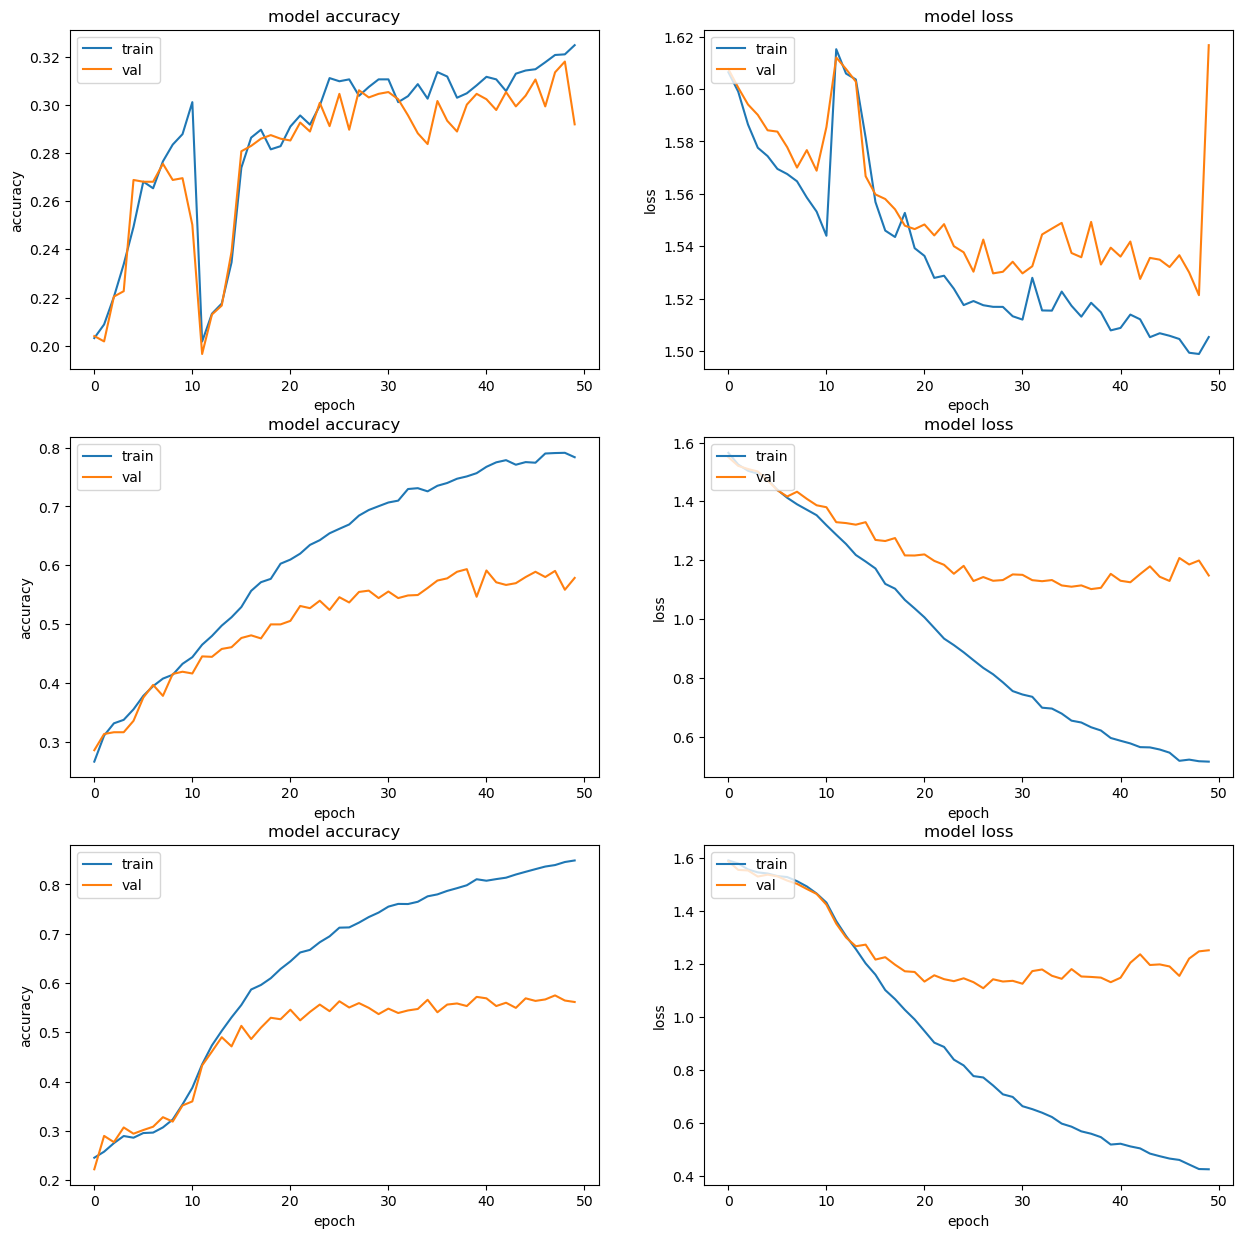

In [15]:
plot_stats(l3)

# With standardization

Standardize samples' matrix<br>The matrix are flatted to an array of features and the resulting dataset is transformed to have mean 0 and std 1

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [17]:
data0['x'].flatten().shape

(299068416,)

In [18]:
data0['xs'] = scaler.fit_transform(data0['x'].reshape(8952,-1)).reshape((8952, 261, 128, 1))
data1['xs'] = scaler.fit_transform(data1['x'].reshape(8952,-1)).reshape((8952, 261, 128, 1))
data2['xs'] = scaler.fit_transform(data2['x'].reshape(8952,-1)).reshape((8952, 261, 128, 1))
data3['xs'] = scaler.fit_transform(data3['x'].reshape(8952,-1)).reshape((8952, 261, 128, 1))

In [19]:
data0['xs'].std(), data0['xs'].mean()

(0.99999744, 7.580669e-08)

In [20]:
l00 = train_kfold(get_m, data0['xs'], data0['y'], metadata)

Epoch 1/50
238/238 [==============================] - 5s 16ms/step - loss: 1.5651 - accuracy: 0.2814 - val_loss: 1.5194 - val_accuracy: 0.3135
Epoch 2/50
238/238 [==============================] - 3s 15ms/step - loss: 1.4932 - accuracy: 0.3383 - val_loss: 1.4884 - val_accuracy: 0.3433
Epoch 3/50
238/238 [==============================] - 3s 15ms/step - loss: 1.4631 - accuracy: 0.3520 - val_loss: 1.4252 - val_accuracy: 0.3835
Epoch 4/50
238/238 [==============================] - 3s 15ms/step - loss: 1.4100 - accuracy: 0.4173 - val_loss: 1.4218 - val_accuracy: 0.3969
Epoch 5/50
238/238 [==============================] - 4s 15ms/step - loss: 1.3934 - accuracy: 0.4062 - val_loss: 1.3866 - val_accuracy: 0.4103
Epoch 6/50
238/238 [==============================] - 3s 15ms/step - loss: 1.3483 - accuracy: 0.4430 - val_loss: 1.3449 - val_accuracy: 0.4423
Epoch 7/50
238/238 [==============================] - 3s 15ms/step - loss: 1.3033 - accuracy: 0.4762 - val_loss: 1.3200 - val_accuracy: 0.4624

Epoch 8/50
238/238 [==============================] - 3s 14ms/step - loss: 1.4885 - accuracy: 0.3437 - val_loss: 1.4901 - val_accuracy: 0.3299
Epoch 9/50
238/238 [==============================] - 3s 14ms/step - loss: 1.4697 - accuracy: 0.3458 - val_loss: 1.4842 - val_accuracy: 0.3269
Epoch 10/50
238/238 [==============================] - 3s 14ms/step - loss: 1.4721 - accuracy: 0.3519 - val_loss: 1.4855 - val_accuracy: 0.3366
Epoch 11/50
238/238 [==============================] - 3s 14ms/step - loss: 1.4550 - accuracy: 0.3618 - val_loss: 1.5046 - val_accuracy: 0.3529
Epoch 12/50
238/238 [==============================] - 3s 15ms/step - loss: 1.4605 - accuracy: 0.3690 - val_loss: 1.4603 - val_accuracy: 0.3686
Epoch 13/50
238/238 [==============================] - 3s 15ms/step - loss: 1.4497 - accuracy: 0.3702 - val_loss: 1.4490 - val_accuracy: 0.3783
Epoch 14/50
238/238 [==============================] - 3s 14ms/step - loss: 1.4276 - accuracy: 0.3837 - val_loss: 1.4478 - val_accuracy: 0

Epoch 15/50
238/238 [==============================] - 3s 15ms/step - loss: 0.9587 - accuracy: 0.6512 - val_loss: 1.0392 - val_accuracy: 0.6024
Epoch 16/50
238/238 [==============================] - 3s 15ms/step - loss: 0.9141 - accuracy: 0.6557 - val_loss: 1.0238 - val_accuracy: 0.5860
Epoch 17/50
238/238 [==============================] - 4s 15ms/step - loss: 0.8823 - accuracy: 0.6794 - val_loss: 1.0078 - val_accuracy: 0.6091
Epoch 18/50
238/238 [==============================] - 3s 15ms/step - loss: 0.8463 - accuracy: 0.6908 - val_loss: 0.9659 - val_accuracy: 0.6337
Epoch 19/50
238/238 [==============================] - 3s 15ms/step - loss: 0.8215 - accuracy: 0.6982 - val_loss: 0.9635 - val_accuracy: 0.6292
Epoch 20/50
238/238 [==============================] - 3s 14ms/step - loss: 0.7972 - accuracy: 0.7154 - val_loss: 0.9162 - val_accuracy: 0.6426
Epoch 21/50
238/238 [==============================] - 3s 14ms/step - loss: 0.7432 - accuracy: 0.7343 - val_loss: 0.8874 - val_accuracy:

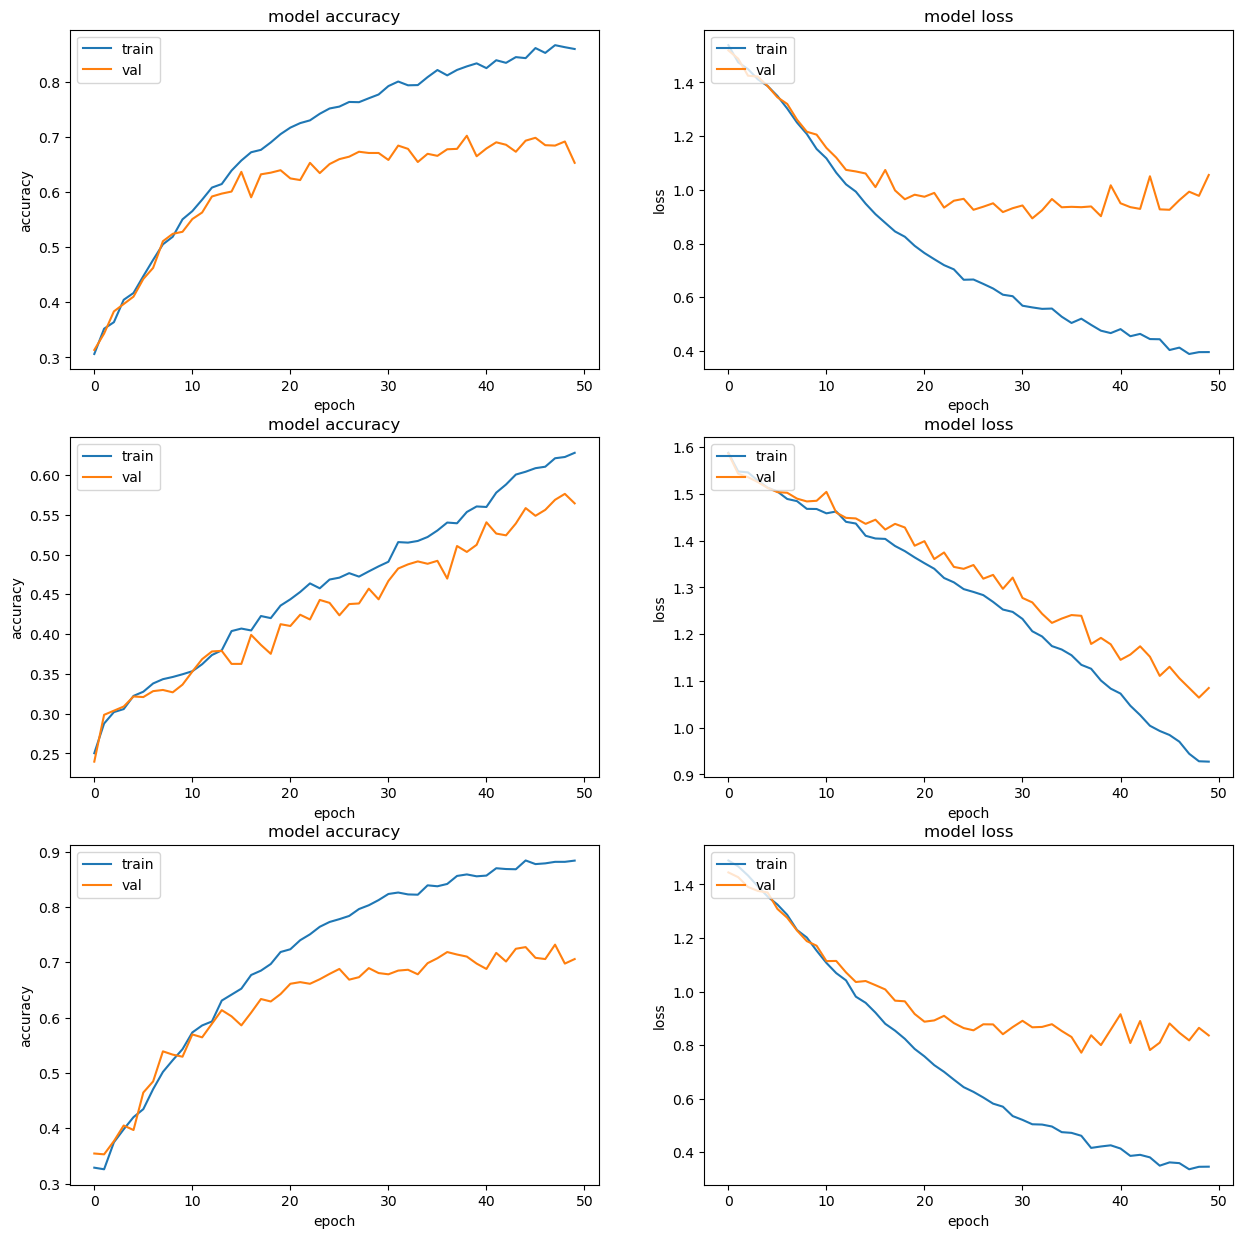

In [21]:
plot_stats(l00)

In [22]:
l11 = train_kfold(get_m, data1['xs'], data1['y'], metadata)


Epoch 1/50
238/238 [==============================] - 5s 16ms/step - loss: 1.6068 - accuracy: 0.2017 - val_loss: 1.6094 - val_accuracy: 0.2063
Epoch 2/50
238/238 [==============================] - 3s 15ms/step - loss: 1.6095 - accuracy: 0.1991 - val_loss: 1.6093 - val_accuracy: 0.2063
Epoch 3/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6093 - accuracy: 0.2009 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 4/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6095 - accuracy: 0.2075 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 5/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6093 - accuracy: 0.2063 - val_loss: 1.6093 - val_accuracy: 0.2063
Epoch 6/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6095 - accuracy: 0.2070 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 7/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6093 - accuracy: 0.2015 - val_loss: 1.6092 - val_accuracy: 0.2063

Epoch 8/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6092 - accuracy: 0.2032 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 9/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6096 - accuracy: 0.1977 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 10/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6093 - accuracy: 0.2122 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 11/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6088 - accuracy: 0.2122 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 12/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6094 - accuracy: 0.2060 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 13/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6095 - accuracy: 0.1994 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 14/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6092 - accuracy: 0.2116 - val_loss: 1.6092 - val_accuracy: 0

Epoch 15/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6091 - accuracy: 0.2087 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 16/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6096 - accuracy: 0.1987 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 17/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6094 - accuracy: 0.2043 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 18/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6087 - accuracy: 0.2106 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 19/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6092 - accuracy: 0.2051 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 20/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6092 - accuracy: 0.2082 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 21/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6093 - accuracy: 0.2110 - val_loss: 1.6092 - val_accuracy:

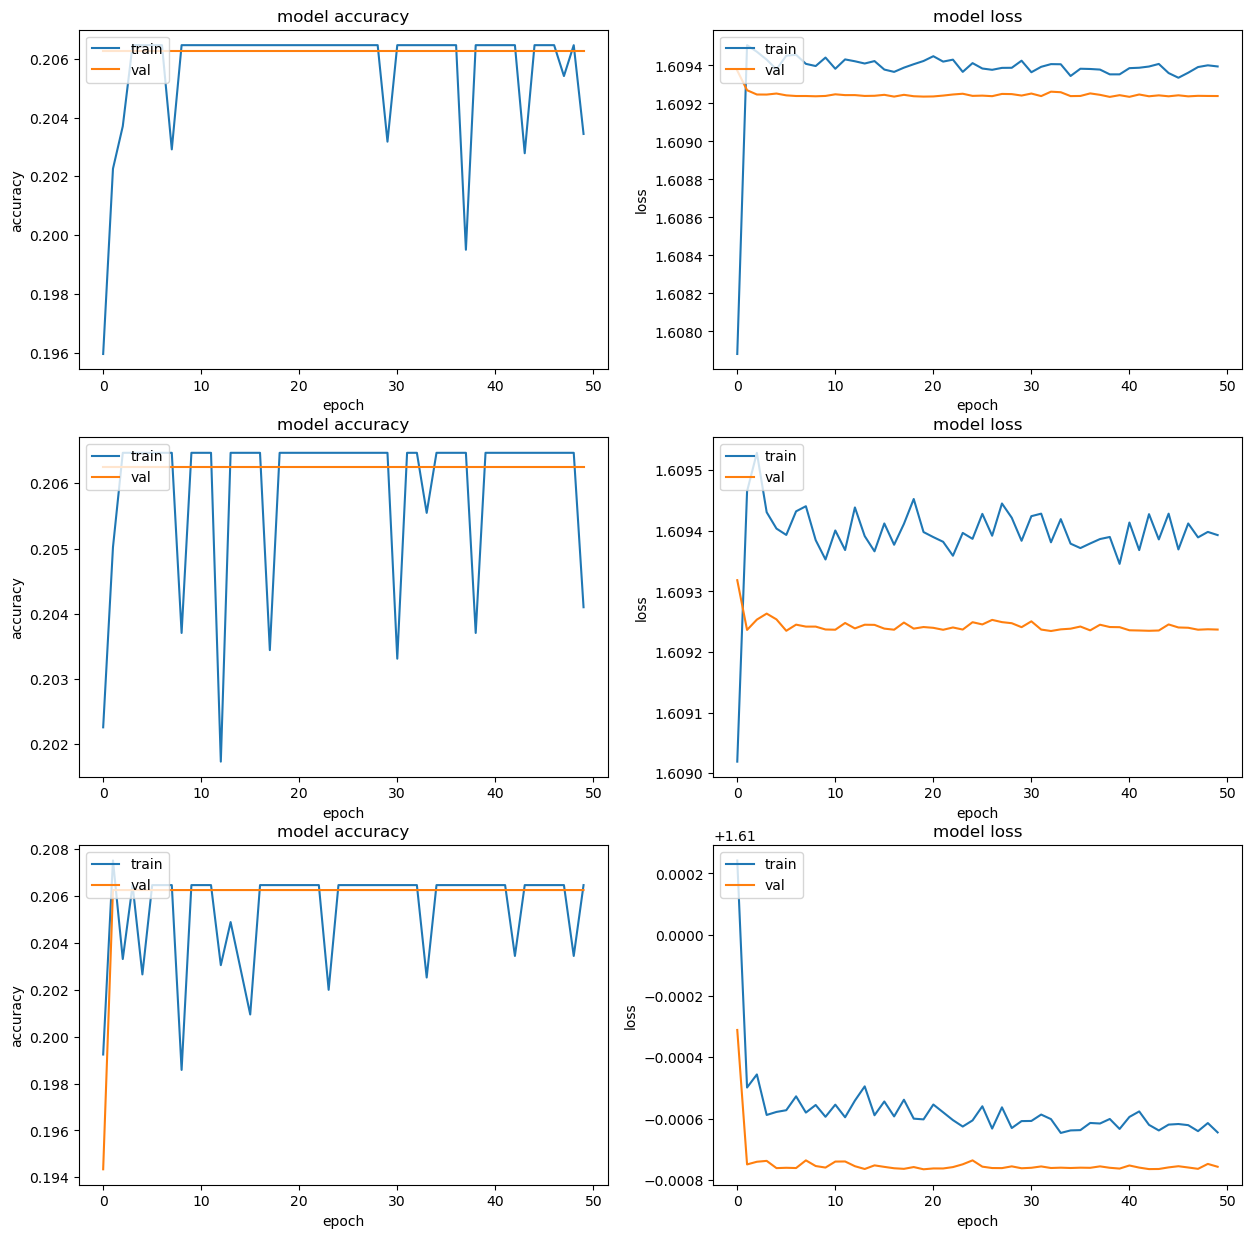

In [23]:
plot_stats(l11)

In [24]:
l22 = train_kfold(get_m, data2['xs'], data2['y'], metadata)

Epoch 1/50
238/238 [==============================] - 5s 16ms/step - loss: 1.5912 - accuracy: 0.2714 - val_loss: 1.6095 - val_accuracy: 0.2018
Epoch 2/50
238/238 [==============================] - 3s 15ms/step - loss: 1.6098 - accuracy: 0.2016 - val_loss: 1.6095 - val_accuracy: 0.2003
Epoch 3/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6093 - accuracy: 0.1991 - val_loss: 1.6093 - val_accuracy: 0.2063
Epoch 4/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6096 - accuracy: 0.2048 - val_loss: 1.6093 - val_accuracy: 0.2063
Epoch 5/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6094 - accuracy: 0.2052 - val_loss: 1.6093 - val_accuracy: 0.2063
Epoch 6/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6095 - accuracy: 0.2029 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 7/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6096 - accuracy: 0.2041 - val_loss: 1.6093 - val_accuracy: 0.2063

Epoch 8/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6091 - accuracy: 0.2013 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 9/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6092 - accuracy: 0.2095 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 10/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6092 - accuracy: 0.2103 - val_loss: 1.6093 - val_accuracy: 0.2063
Epoch 11/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6090 - accuracy: 0.2067 - val_loss: 1.6093 - val_accuracy: 0.2063
Epoch 12/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6091 - accuracy: 0.2132 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 13/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6096 - accuracy: 0.2011 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 14/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6097 - accuracy: 0.1991 - val_loss: 1.6092 - val_accuracy: 0

Epoch 15/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6095 - accuracy: 0.2021 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 16/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6096 - accuracy: 0.2033 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 17/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6093 - accuracy: 0.2014 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 18/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6094 - accuracy: 0.2058 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 19/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6090 - accuracy: 0.2068 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 20/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6094 - accuracy: 0.2029 - val_loss: 1.6093 - val_accuracy: 0.2063
Epoch 21/50
238/238 [==============================] - 3s 14ms/step - loss: 1.6096 - accuracy: 0.2002 - val_loss: 1.6092 - val_accuracy:

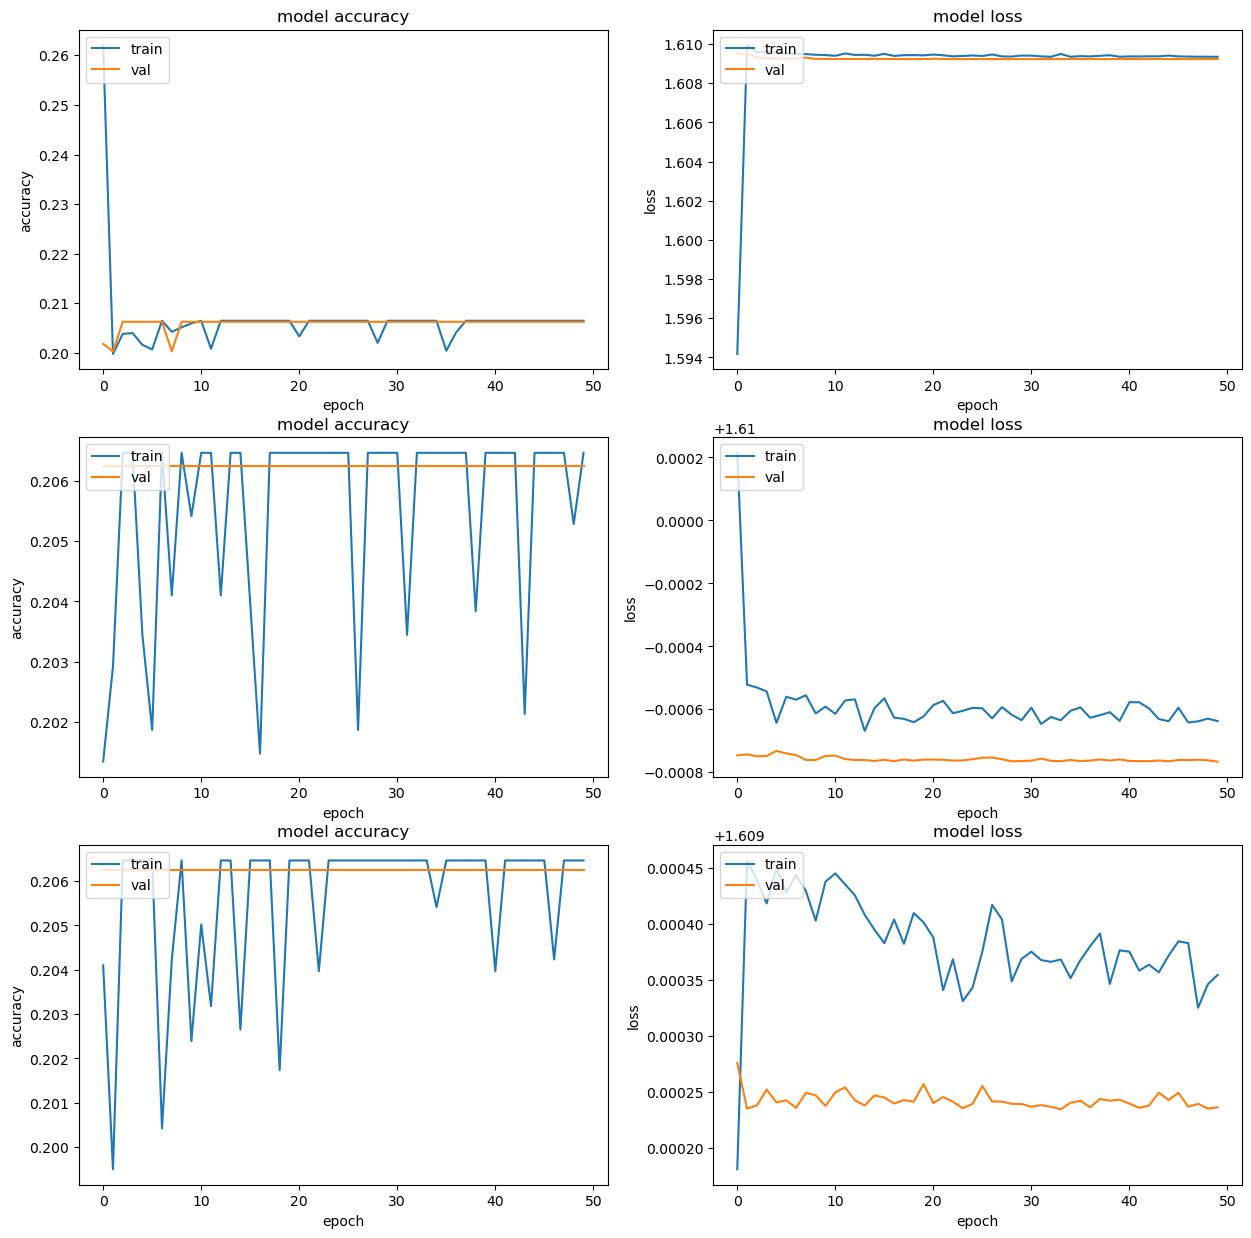

In [25]:
plot_stats(l22)

In [26]:
l33 = train_kfold(get_m, data3['xs'], data3['y'], metadata)

Epoch 1/50
238/238 [==============================] - 5s 16ms/step - loss: 1.5609 - accuracy: 0.2761 - val_loss: 1.5345 - val_accuracy: 0.3112
Epoch 2/50
238/238 [==============================] - 3s 15ms/step - loss: 1.4788 - accuracy: 0.3573 - val_loss: 1.4506 - val_accuracy: 0.3835
Epoch 3/50
238/238 [==============================] - 3s 15ms/step - loss: 1.4218 - accuracy: 0.3870 - val_loss: 1.4225 - val_accuracy: 0.3999
Epoch 4/50
238/238 [==============================] - 3s 14ms/step - loss: 1.3709 - accuracy: 0.4423 - val_loss: 1.3642 - val_accuracy: 0.4430
Epoch 5/50
238/238 [==============================] - 3s 14ms/step - loss: 1.3151 - accuracy: 0.4865 - val_loss: 1.3328 - val_accuracy: 0.4691
Epoch 6/50
238/238 [==============================] - 3s 15ms/step - loss: 1.2450 - accuracy: 0.5094 - val_loss: 1.3080 - val_accuracy: 0.4847
Epoch 7/50
238/238 [==============================] - 3s 14ms/step - loss: 1.1959 - accuracy: 0.5264 - val_loss: 1.3701 - val_accuracy: 0.4415

Epoch 8/50
238/238 [==============================] - 3s 15ms/step - loss: 1.4010 - accuracy: 0.4189 - val_loss: 1.3933 - val_accuracy: 0.4140
Epoch 9/50
238/238 [==============================] - 3s 14ms/step - loss: 1.3671 - accuracy: 0.4324 - val_loss: 1.3883 - val_accuracy: 0.4133
Epoch 10/50
238/238 [==============================] - 3s 15ms/step - loss: 1.3376 - accuracy: 0.4463 - val_loss: 1.3628 - val_accuracy: 0.4356
Epoch 11/50
238/238 [==============================] - 3s 15ms/step - loss: 1.3016 - accuracy: 0.4705 - val_loss: 1.3407 - val_accuracy: 0.4602
Epoch 12/50
238/238 [==============================] - 3s 15ms/step - loss: 1.2801 - accuracy: 0.4722 - val_loss: 1.3117 - val_accuracy: 0.4624
Epoch 13/50
238/238 [==============================] - 3s 15ms/step - loss: 1.2423 - accuracy: 0.5043 - val_loss: 1.2852 - val_accuracy: 0.4676
Epoch 14/50
238/238 [==============================] - 3s 14ms/step - loss: 1.2014 - accuracy: 0.5147 - val_loss: 1.2817 - val_accuracy: 0

Epoch 15/50
238/238 [==============================] - 3s 15ms/step - loss: 1.1051 - accuracy: 0.5781 - val_loss: 1.1605 - val_accuracy: 0.5495
Epoch 16/50
238/238 [==============================] - 4s 15ms/step - loss: 1.0526 - accuracy: 0.6063 - val_loss: 1.1392 - val_accuracy: 0.5592
Epoch 17/50
238/238 [==============================] - 3s 15ms/step - loss: 1.0082 - accuracy: 0.6259 - val_loss: 1.1289 - val_accuracy: 0.5562
Epoch 18/50
238/238 [==============================] - 3s 15ms/step - loss: 0.9780 - accuracy: 0.6374 - val_loss: 1.1143 - val_accuracy: 0.5510
Epoch 19/50
238/238 [==============================] - 3s 15ms/step - loss: 0.9190 - accuracy: 0.6608 - val_loss: 1.0802 - val_accuracy: 0.5681
Epoch 20/50
238/238 [==============================] - 3s 15ms/step - loss: 0.8881 - accuracy: 0.6661 - val_loss: 1.0877 - val_accuracy: 0.5674
Epoch 21/50
238/238 [==============================] - 3s 15ms/step - loss: 0.8582 - accuracy: 0.6885 - val_loss: 1.0388 - val_accuracy:

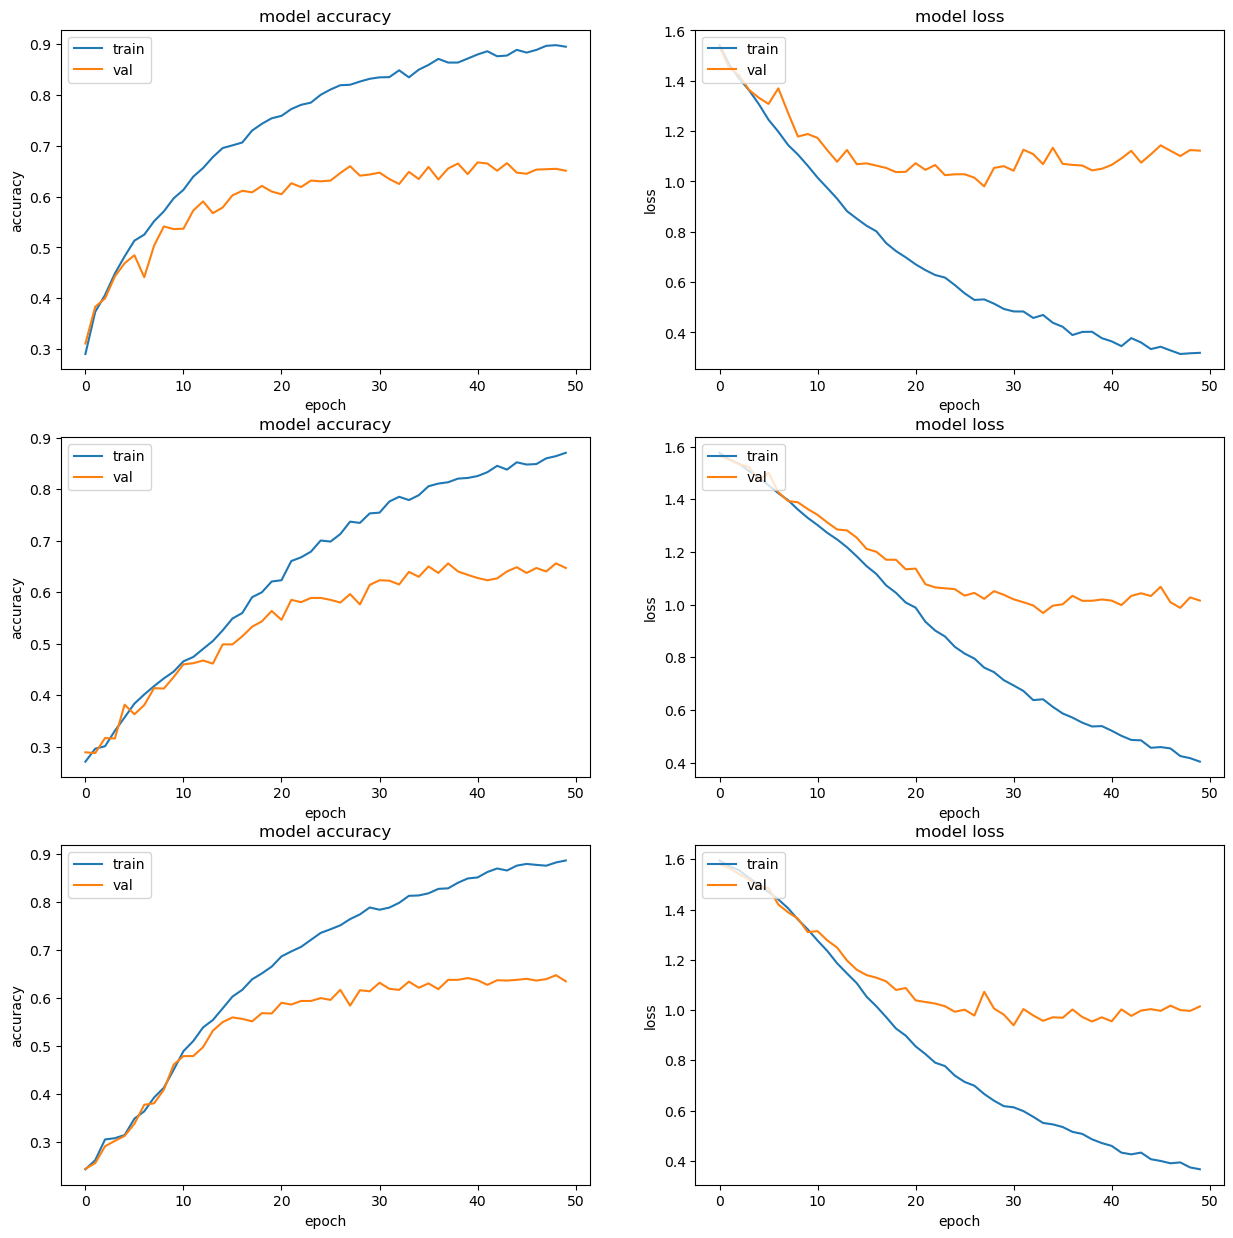

In [27]:
plot_stats(l33)